In [1]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from time import sleep
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
from matplotlib import animation
from collections import defaultdict

class Cell:
    cell_counter = 0
    def __init__(self,label, contours, contour_index,centroid=None,cell_img=None):
        self.label = Cell.cell_counter
        Cell.cell_counter = Cell.cell_counter + 1
        self.contours = contours   #####cell with its contour
        self.colour = tuple(np.floor(np.random.random(size=3)*256))     #####colour of the contour of the cell
        self.centroid = centroid      #####centroid of the cell
        self.centroidHistory = []     #####centroid History of the cell
        self.cellAsImageFromPrevFrame = cell_img     #####cell from the previous image
        self.contourIndex = contour_index       ####Contour Index
        self.image_states = []
        
        
    def getColor(self):
        print("Cell label",self.label,"Colour for cell",self.color,"Cell_Coords",self.centroid)
        
    def getCellAsImagePrevFrame(self):
        #plt.figure(figsize=(20,20))
        #plt.imshow(self.cellAsImageFromPrevFrame)
        #plt.show()
        return self.cellAsImageFromPrevFrame     #####Cell as Image from previous frame
    
    def cell_disappear(self):
        self.contour = None                   ####If the cell disappears, from image, remove contour
        self.centroid = None                  ####remove centroid
        self.cellAsImageFromPrevFrame = None  ####cell as Image from Previous Frame
        self.colour = None                    ####colour
        self.centroidHistory.append(-1)       ####centroidHistory
        
    def cell_update(self, centroid, cell_img, contours, contour_index,img_num):
        self.image_states.append((cell_img,centroid,img_num))
        self.centroidHistory.append(self.centroid) ####update the history of centroids
        self.cellAsImageFromPrevFrame = cell_img   ####cellAsImagefromPrevFrame
        self.contours = contours                ####cell as contour
        self.contourIndex = contour_index
        self.centroid = centroid
        #print("centroid history updated: ")
        #print(len(self.centroidHistory))
        
class ImageProcessor:
    def __init__(self):
        self.cells = []                       ###stores the cells object
        self.cv2Contours = None               ###cv2Contours is none
            
    def preProcessImage(self,img,seq_num,img_num):
        kernel = np.ones((6,6),np.uint8)
        kernel_big = np.ones((18,18),np.uint8)

        if (seq_num == 2 or seq_num == 4) and img_num == 0:
            closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_big)
            t,preprocessed_img = cv2.threshold(self.contrastStretchImg(closed_img), 0, 255, cv2.THRESH_BINARY)
        else:
            closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
            t,preprocessed_img = cv2.threshold(self.contrastStretchImg(closed_img), 0, 255, cv2.THRESH_BINARY)
            preprocessed_img = np.uint8(preprocessed_img)

        return preprocessed_img
    
    def contrastStretchImg(self,img):
        min_gbl = 0
        max_gbl = 255
        
        
        min_lcl = np.min(img)
        max_lcl = np.max(img)
        
        newImg = img.copy()
        newImg = (img - min_lcl)*((max_gbl - min_gbl) / (max_lcl - min_lcl)) + min_gbl
        
        return newImg
    def segmentImage(self,img):
        ##Generating contours for each cell
        ##Calculate the centroid of each cell in the image
        
        contours = None
        centroids = None
        
        #Find contours
        if cv2.__version__ =='4.5.3':
            contours, heirarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        else:
            _, contours, heirarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #contours,hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        centroids = []
        
        for i, cnt in enumerate(contours):
            m = cv2.moments(cnt)
            if m['m00'] != 0:
                centerX = int(m['m10']/m['m00'])
                centerY = int(m['m01']/m['m00'])
                area = cv2.contourArea(cnt)
                if area > 5.0:
                    centroids.append([centerX,centerY])
                    
        self.cv2Contours = contours
        return (contours,centroids)
    
    def drawContours(self,img):
        for cell in self.cells:
            if cell.contourIndex < len(self.cv2Contours)-1 :
                cv2.drawContours(img, self.cv2Contours, cell.contourIndex, cell.colour,1)
        
    def drawId(self,img):
        for cell in self.cells:
            if cell.centroid != None:
                cv2.putText(img,str(cell.label), (cell.centroid[0], cell.centroid[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    def spot_mitosis(self,img,orig_img,contours):
        count = 0
        mitosis = 0
        for i in range(len(contours)):
            if len(contours[i])>=5:
                count += 1
                elps = cv2.fitEllipse(contours[i])
                if len(elps)==3:
                    coords,axes,r = elps
                    x,y = coords
                    major_axis,minor_axis = axes
                    if major_axis > 0:
                        ratio = minor_axis / major_axis
                        if ratio >=2.3:
                            if math.isinf(x) or math.isinf(y) or math.isinf(major_axis) or math.isinf(minor_axis) or math.isnan(x) or math.isnan(y) or math.isnan(major_axis) or math.isnan(minor_axis):
                                continue
                            mitosis +=1
                            image = cv2.circle(orig_img, (int(x),int(y)),30,(0,0,255),3)
                            
                    else:
                        image = orig_img
            else:
                image = orig_img
        
        image = orig_img
        return image,count,mitosis
        
    # Associate current cells with registered cells 
    # and update cell data (register unidentified cells)
    # Sparse motion estimation (week 7 lecture 1)
    def identifyCells(self, img, contours, centroids,img_num):
        count = 0
        img_width, img_height = img.shape    ###get the dimensions of the image
        centroids_template = [] ###stores all the centroid we have found while matching

        #Interesting points: the list of cells from the previous iterations
        for cell in self.cells: 
            #Ignore any cells that have diappeared
            if cell.centroid == None:
                continue

            curr_contours = contours
            


            #Compare previous contour with all of the current contours and find the best one
            contour_prev = cell.contours[cell.contourIndex]
            prev_moment = cv2.moments(contour_prev)
            if prev_moment['m00'] == 0:
                continue
            prev_centerX = int(prev_moment['m10']/prev_moment['m00'])
            prev_centerY = int(prev_moment['m01']/prev_moment['m00'])
            best_contour = None
            
            match_threshold = 0.5
            best_distance = img_width // 4
            best_contour_index = None
            for i, curr_contour in enumerate(curr_contours):
                curr_moment= cv2.moments(curr_contour)
                if curr_moment['m00'] != 0:
                    current_centerX = int(curr_moment['m10']/curr_moment['m00'])
                    current_centerY = int(curr_moment['m01']/curr_moment['m00'])
                    distance = abs(current_centerX - prev_centerX) + abs(current_centerY - prev_centerY)
                    
                    match_val = cv2.matchShapes(contour_prev, curr_contour,1,0.0)
                    #current_score = #???
                    #print(match_val,distance,img_width // 4)
                    if match_val < match_threshold and distance < best_distance:
                        best_contour = curr_contour
                        best_contour_index = i
                        best_distance = distance
            

            if best_distance < img_width // 4:
                # A match is found
                #   -> add location to the previous locations of the matched cell
                m = cv2.moments(best_contour)
                if m['m00']!= 0: 
                    centerX = int(m['m10']/m['m00'])
                    centerY = int(m['m01']/m['m00'])
                    centroids.append([centerX,centerY])
                    #crop the section around the cell using contours (get better bounds)
                    x, y, w, h = cv2.boundingRect(best_contour)
                    cell_img = img.copy()[ y : y + h, x : x + w] 
                    cell_centroid = [centerX,centerY]
                    cell.cell_update(cell_centroid, cell_img, curr_contours, best_contour_index,img_num)
                    #cell.getColor()
                    centroids_template.append(cell_centroid)
                
            else:
                # A match is not found, it is a deleted cell
                #   -> centroids become -1, -1, contour becomes None, move to start of list
                cell.cell_disappear()
                self.cells.insert(0, self.cells.pop(self.cells.index(cell)))

        # Compare centroid list with the cell list
        # A cell exists in the list of centroids that isn't in the list of cells, it is a new cell
        #     -> add cell to the list
        # centroids_template_matching vs centroids
        boundary = 2
        for centroid_segmented in centroids:
            found = False
            for centroid_template in centroids_template:
                #Check if they are within 5 pixels of eachother
                if (centroid_segmented[0] - boundary < centroid_template[0] < centroid_segmented[0] + boundary):
                    if (centroid_segmented[1] -  boundary < centroid_template[1] < centroid_segmented[1] + boundary):
                        found = True
                        break
            if found == False:
                label = 0 #TODO: what do you want the label to be?
                contour_index =  centroids.index(centroid_segmented)
                contour = contours[contour_index]
                #crop the section around the cell using contours 
                x, y, w, h = cv2.boundingRect(contour) 
                cell_img = img.copy()[y : y + h, x : x + w]
                self.cells.append(Cell(label, contours, contour_index, centroid_segmented, cell_img))
                count +=1




    def drawTrajectories(self,img):
            
        for cell in self.cells:
            if cell.centroid !=None and len(cell.centroidHistory) > 0:
                #print('Cell Centroid: ',cell.centroid,'Cell Hist: ',cell.centroidHistory)
                start_point = cell.centroid
                difference_x = cell.centroid[0]-cell.centroidHistory[-1][0]
                difference_y = cell.centroid[1]-cell.centroidHistory[-1][1]
                length = np.sqrt(difference_x**2 + difference_y**2)
                #print("Difference values",difference_x,difference_y)                
                #print("Length",length)
                if length > 0:
                    normalised_diff_x = int(difference_x/length)*40
                    normalised_diff_y = int(difference_y/length)*40
                    end_point_x = cell.centroid[0]+normalised_diff_x
                    end_point_y = cell.centroid[1]+normalised_diff_y
                    end_point = (end_point_x,end_point_y)
                    img = cv2.arrowedLine(img, start_point, end_point, cell.colour,2)
        

            


    def drawCellCount(self):
        count = 0
        for cell in self.cells:
            if cell.centroid == None:
                continue
            else:
                count += 1
        print("Number of cells: "+str(count))
        
    def cellOnImgEdge(self,contour):
        for coords in contour:
            if coords[0][0] == 0 or coords[0][1] == 0:
                return True
            
        return False
    
    def drawAverageSize(self,contours):
        areas = []
        num_cells_on_edge = 0
        
        for i in range(len(contours)):
            if self.cellOnImgEdge(contours[i]) == False:
                area = cv2.contourArea(contours[i])
                areas.append(area)
                
        areas = np.array(areas)
        ars = float(np.mean(areas))
        ars = round(ars,3)
        return ars
        
        
    def drawAverageDisplacement(self):
        sum = 0
        num = 0
        for cell in self.cells:
            sum = sum + abs(cell.centroidHistory[-1] - cell.centroidHistory[-2])
            num = num + 1
        return sum / num

    
    def operateOnImage(self,img,img_gray,seq_num,img_num):
        ###Output final image
        original_img = img
        img_gray = self.preProcessImage(img_gray,seq_num,img_num)
        contours, centroids = self.segmentImage(img_gray)
        self.identifyCells(img_gray,contours,centroids,img_num)
        img = cv2.cvtColor(img_gray,cv2.COLOR_GRAY2BGR)
        img,count,mitosis_count = self.spot_mitosis(img,original_img,contours)
        
        self.drawContours(original_img) 
        #self.drawId(img)
        #self.drawCellCount()
        average_cell_area = self.drawAverageSize(contours)
        if img_num > 0:
            self.drawTrajectories(img)
        cv2.putText(original_img,'Number of Cells: '+str(count),(0,30), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,255,0), 2, cv2.LINE_AA)
        cv2.putText(original_img,'Average Cell Areas: '+str(average_cell_area),(0,45), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255,0), 2, cv2.LINE_AA)
        cv2.putText(original_img,'Mitosis Count: '+str(mitosis_count),(0,65), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255,0), 2, cv2.LINE_AA)
                
        return original_img
    

    
    def create_movie(self,folder_path):
        img_array = []
        size = 0
        for file in sorted(os.listdir(folder_path)):
            if file == '.DS_Store':
                continue
            if file.split('.')[0][1:4] == 11:
                break
            path = folder_path + "/" + file
            img = cv2.imread(path)
            height, width, t = img.shape
            size = (width,height)
            img_array.append(img)
            
        out = cv2.VideoWriter('mitosis_overlay_4.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)
        
        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()
        
def main():
    # Create a ImageProcessor object
    img_processor = ImageProcessor()

    # Relative path to the folder where sequences are kept, just change this as needed.
    seq_num = 1
    root_path = "Sequences/0" + str(1) + "/"
    count = 0
    for file in sorted(os.listdir(root_path)):
        count +=1
        if file == '.DS_Store':
            continue
        path = root_path + file
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        file_first= file.split('.')[0]
        img_num= int(file_first[1:])
        print(file)
        annotated_img = img_processor.operateOnImage(img,img_gray,seq_num,img_num)
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        plt.show()
            # Saved the annoted image to a new folder. You must first create this folder and type in the relative path for saving.
        #save_path = "Sequences/Tests/" # change if needed
        #path = save_path + file.split('.')[0] + "_pp.png"
        #cv2.imwrite(path,img)


    #img_processor.create_movie("Sequences/Tests_Overlay")


t000.tif


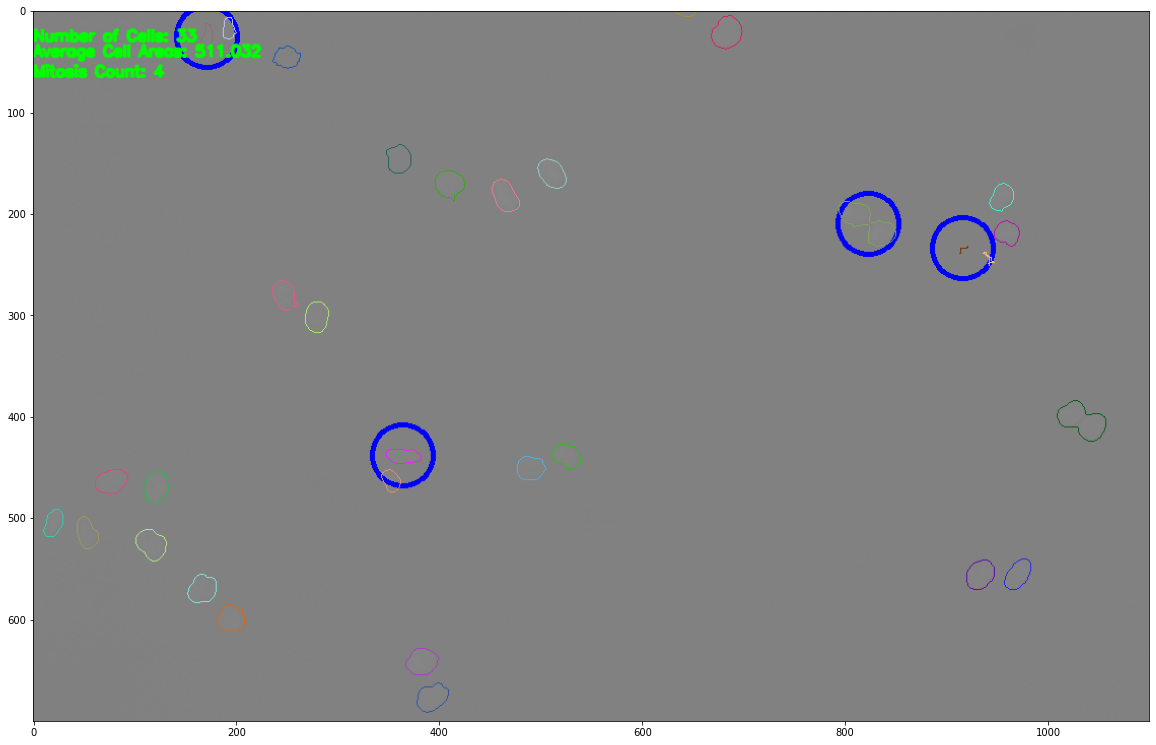

t001.tif


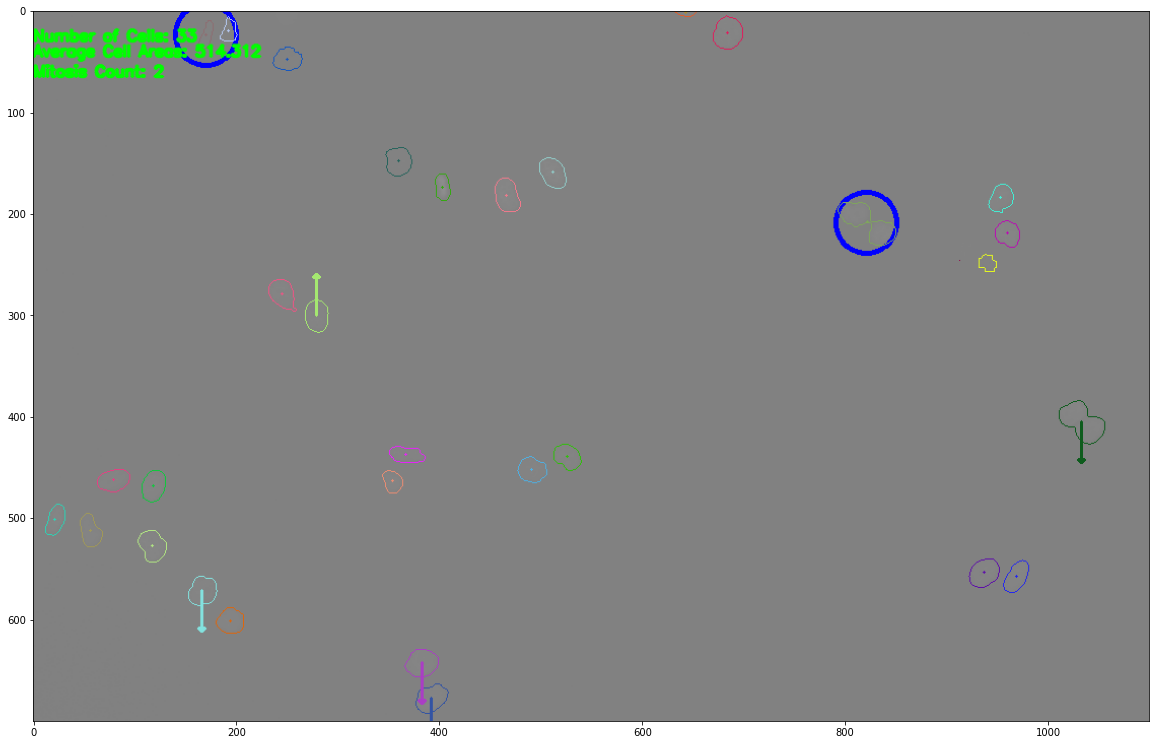

t002.tif


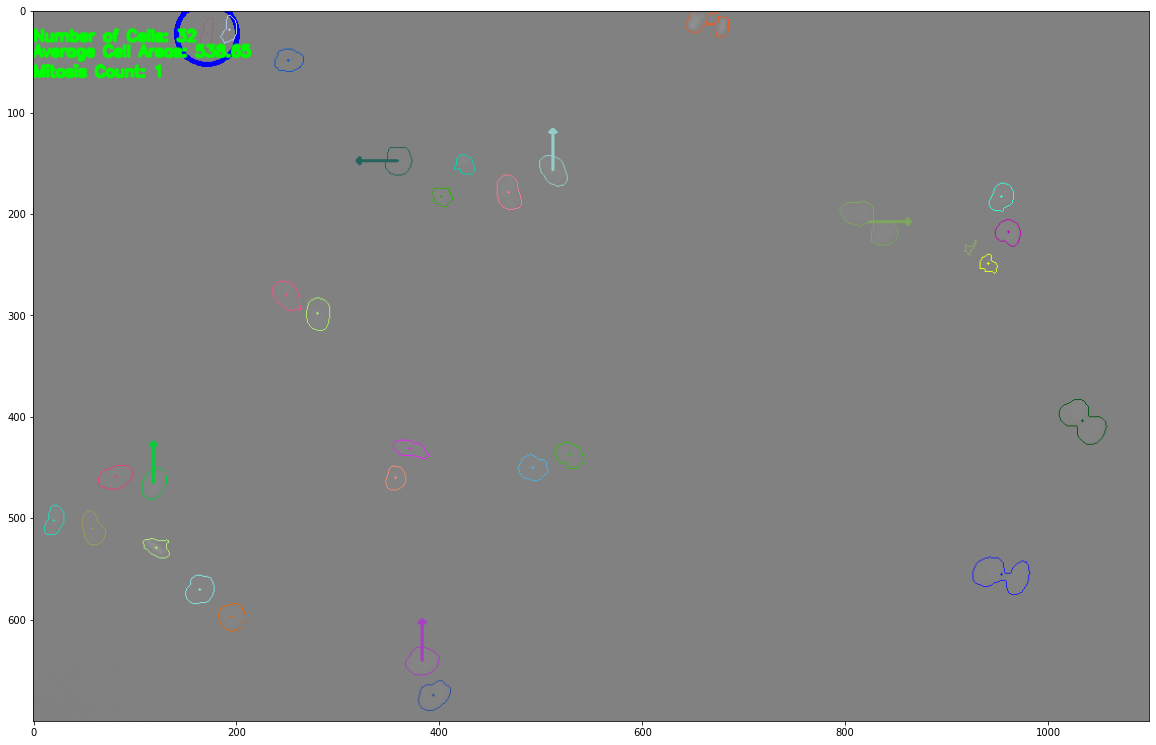

t003.tif


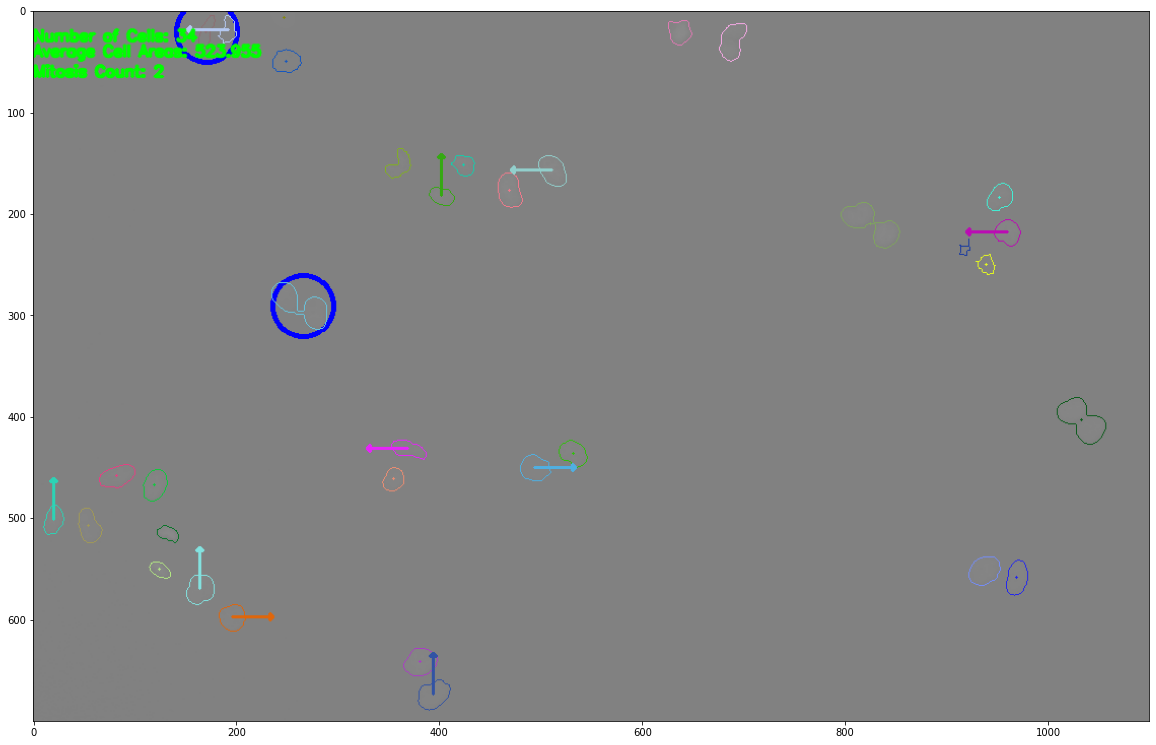

t004.tif


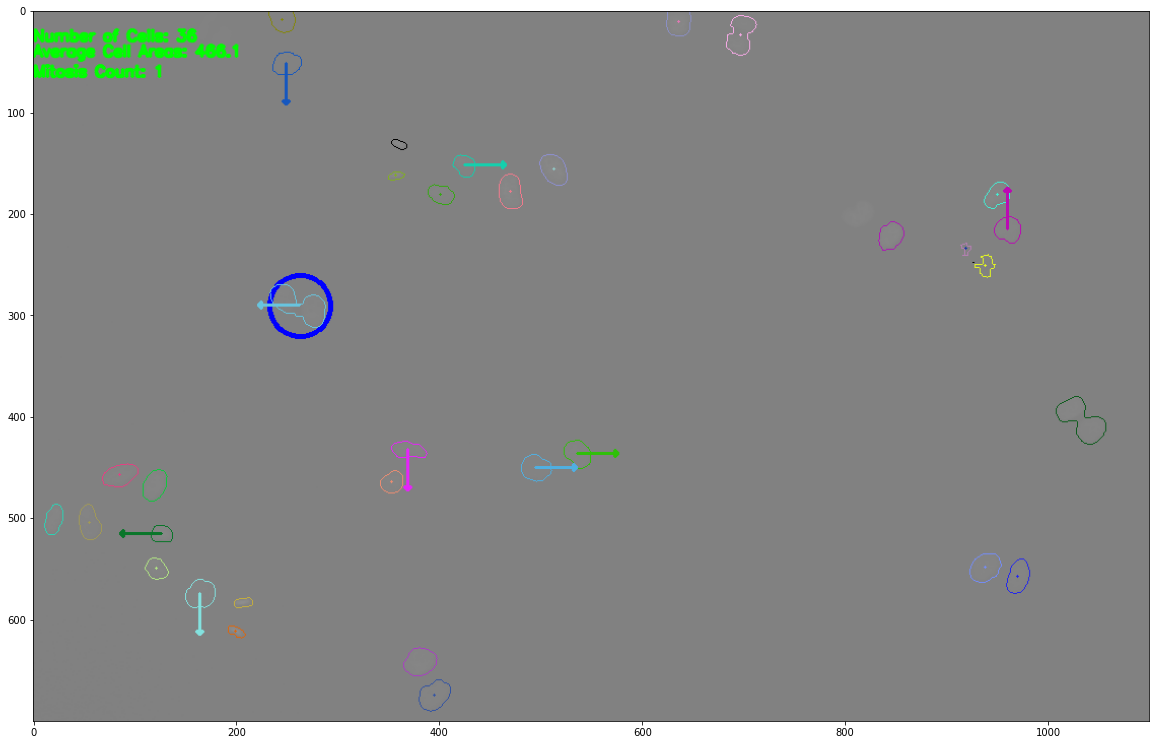

t005.tif


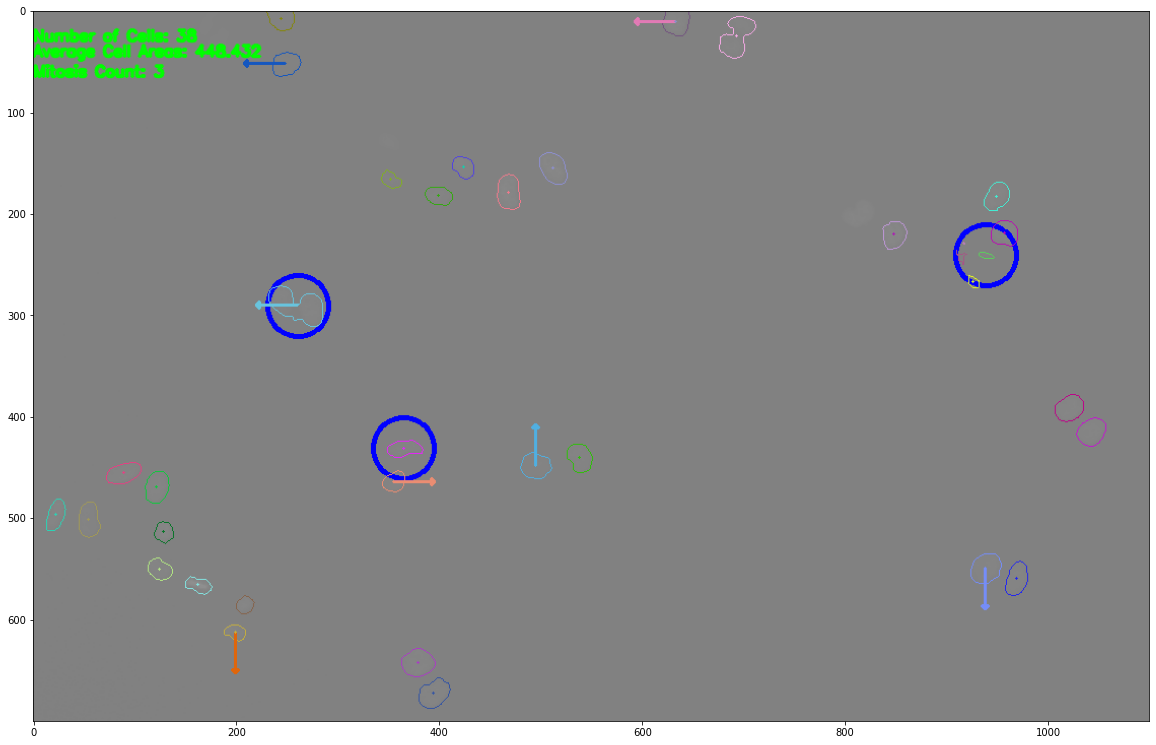

t006.tif


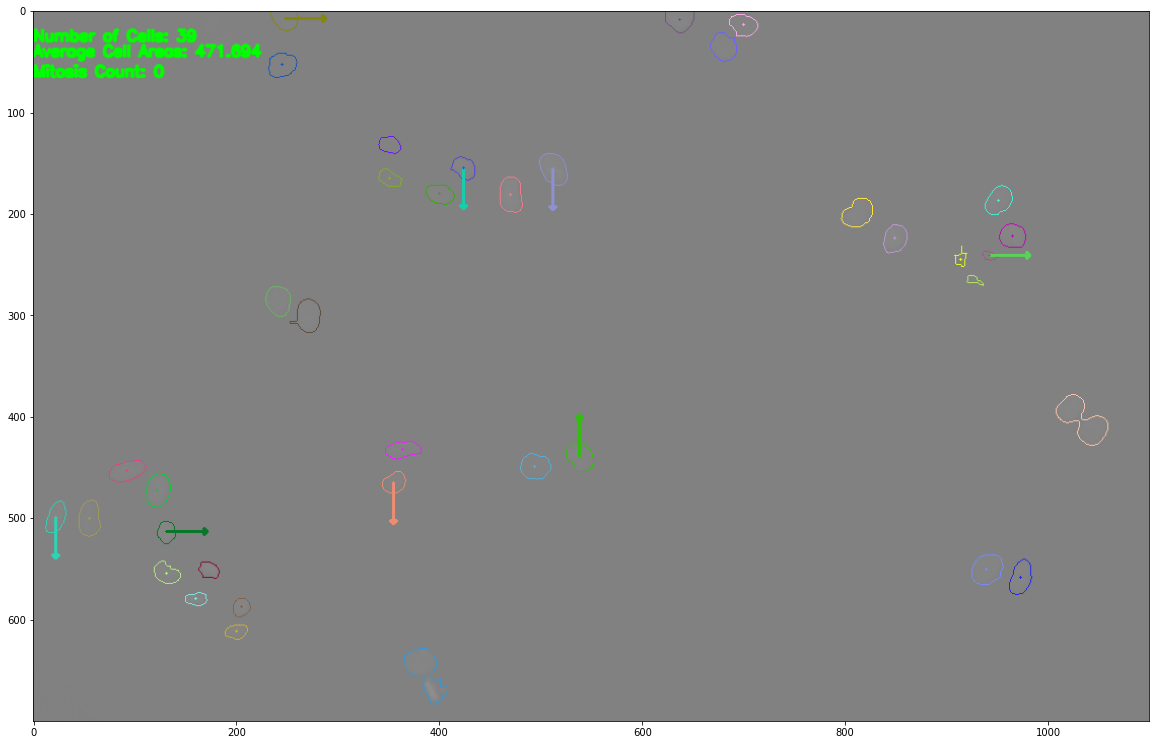

t007.tif


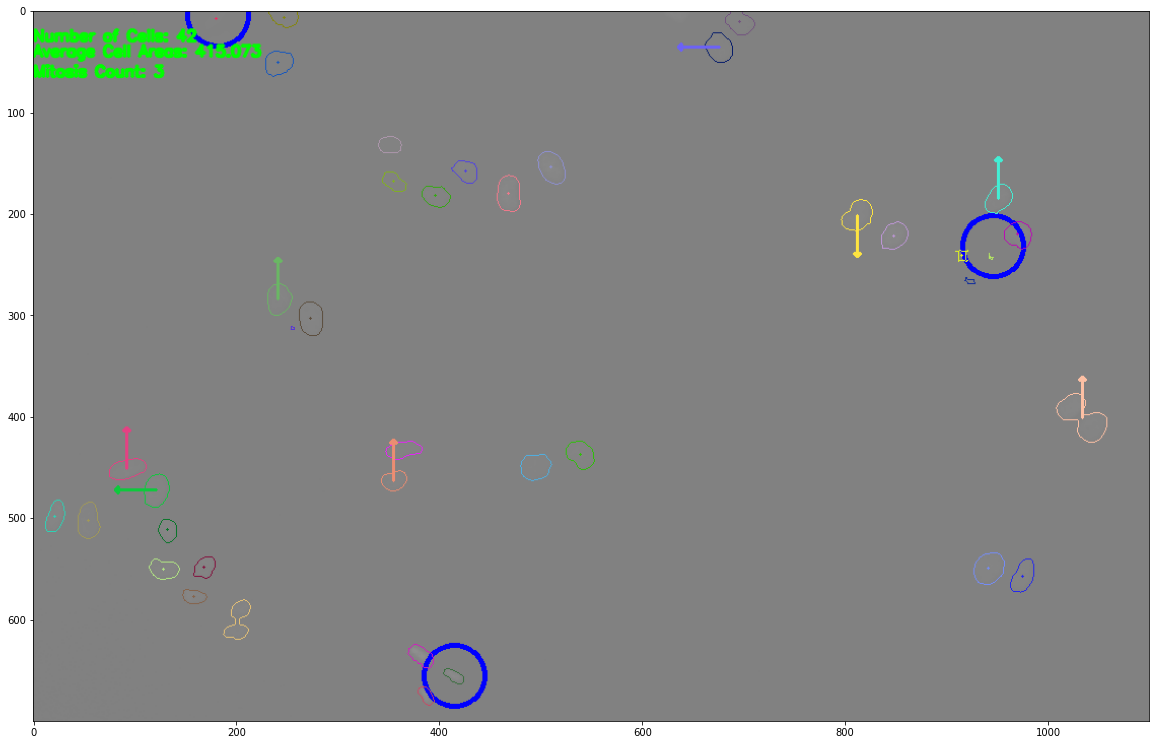

t008.tif


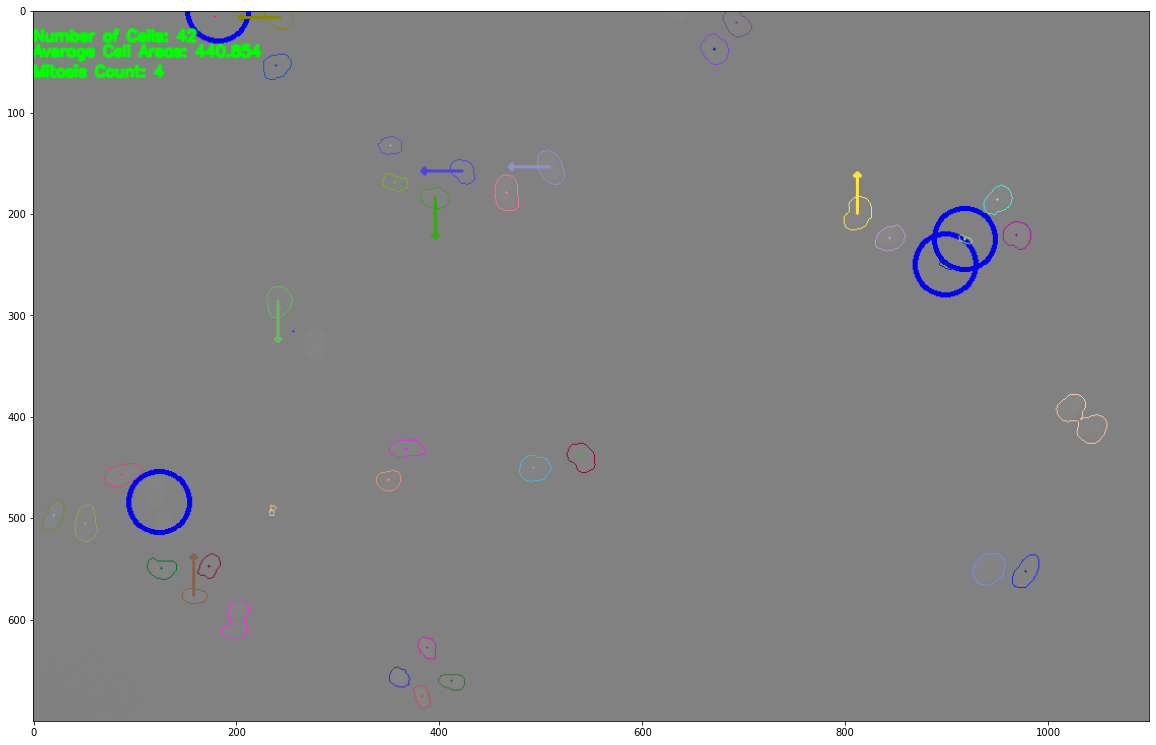

t009.tif


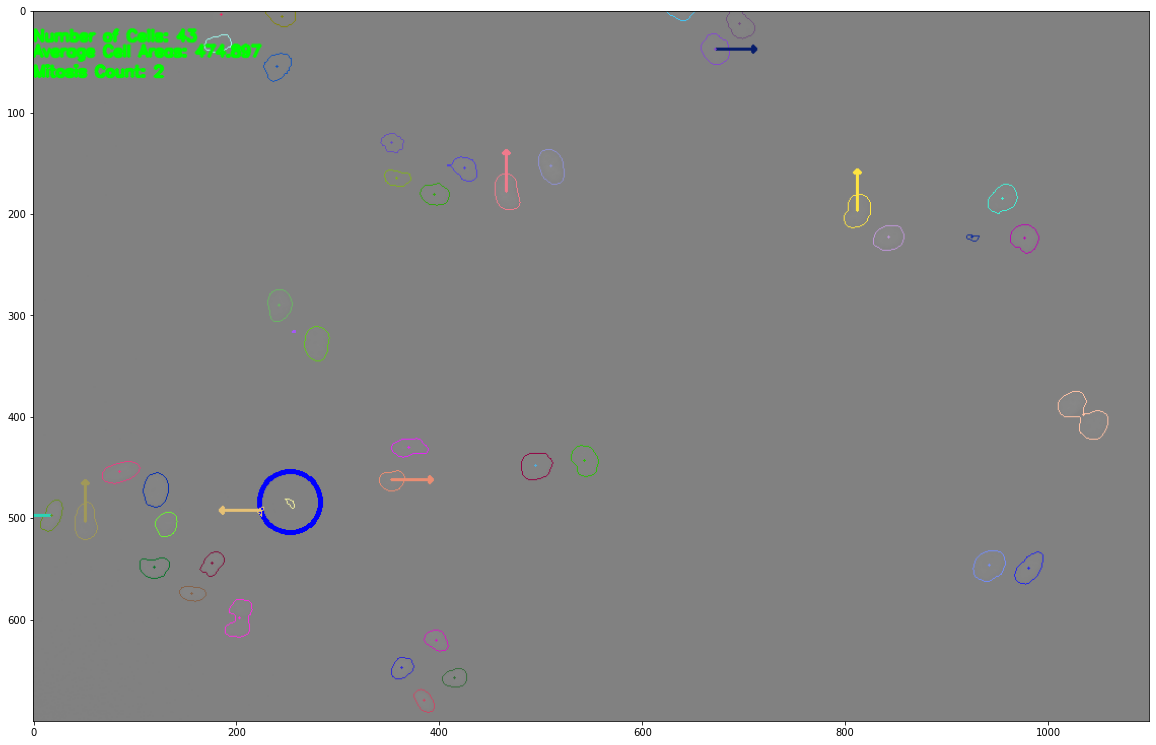

t010.tif


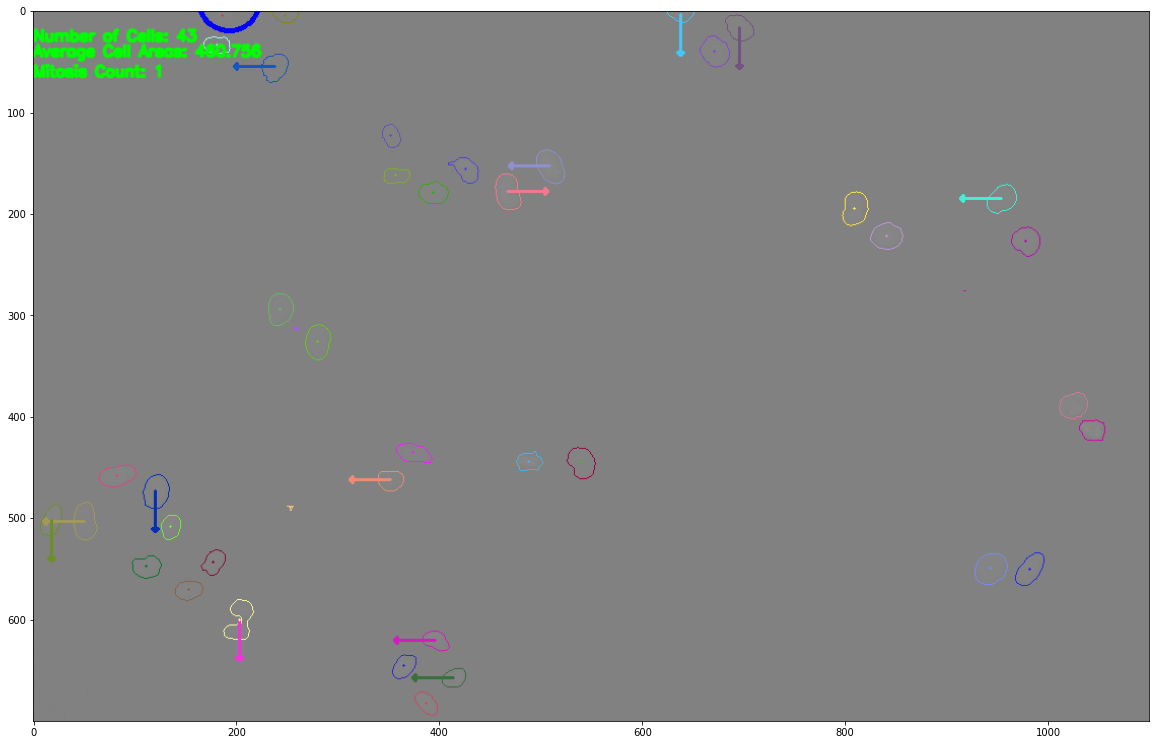

t011.tif


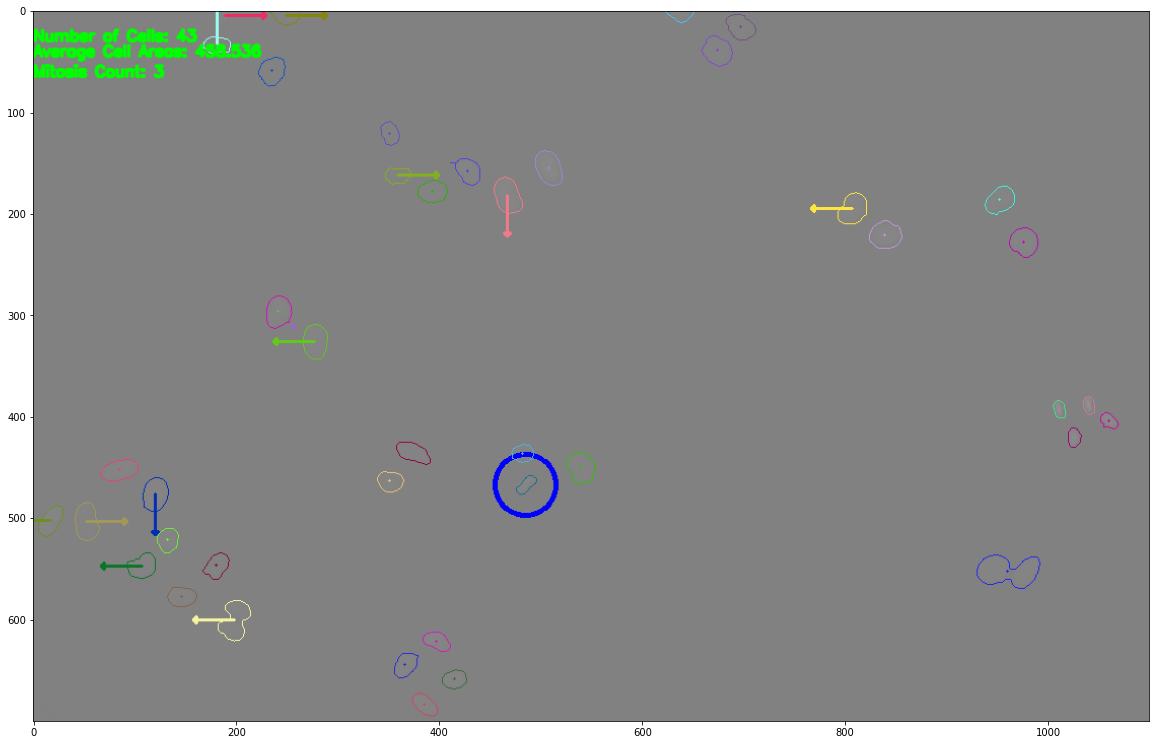

t012.tif


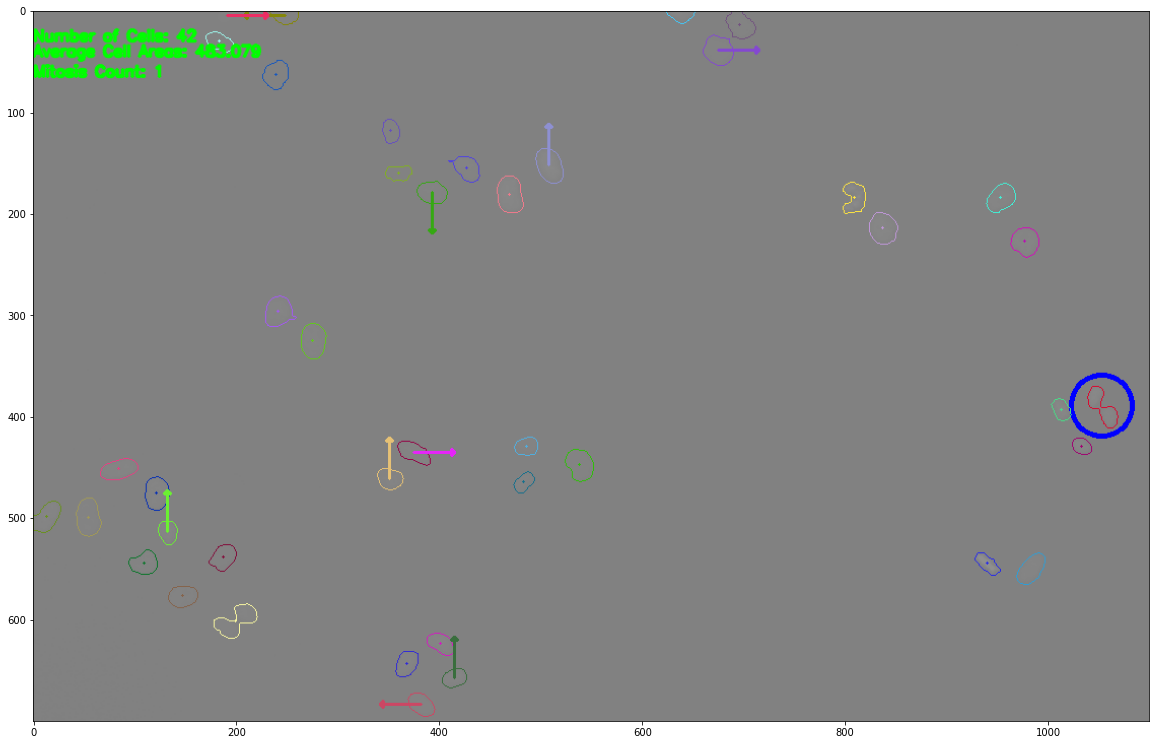

t013.tif


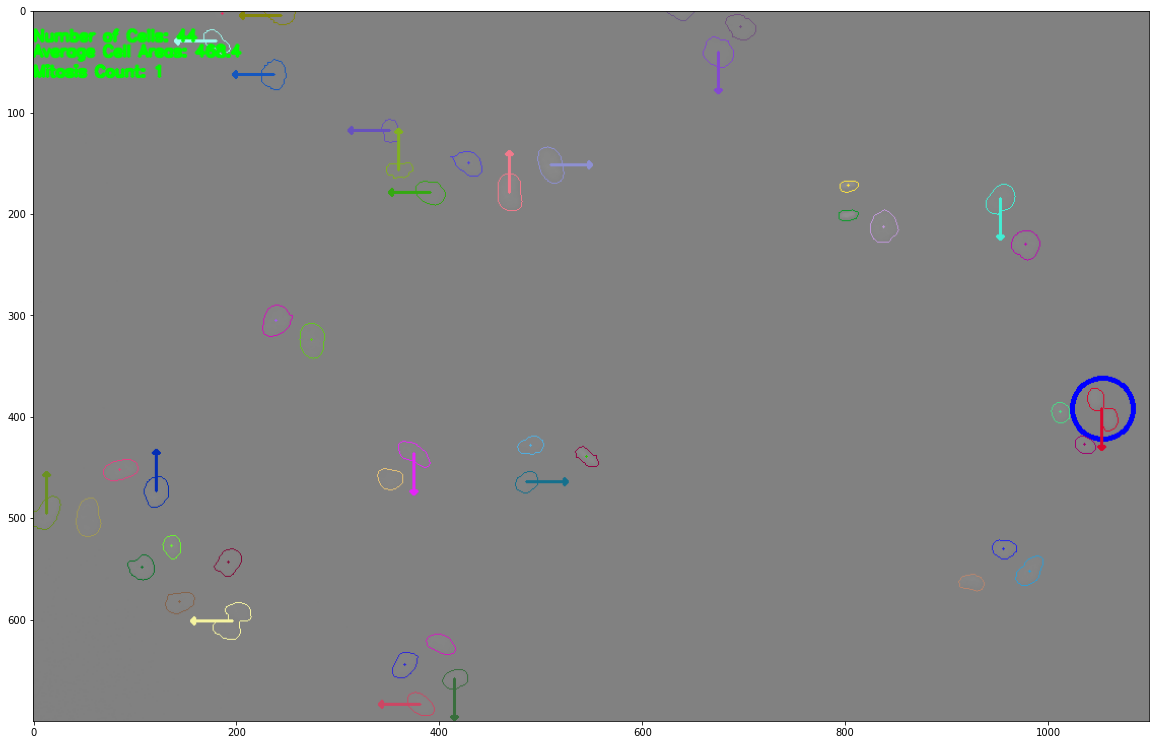

t014.tif


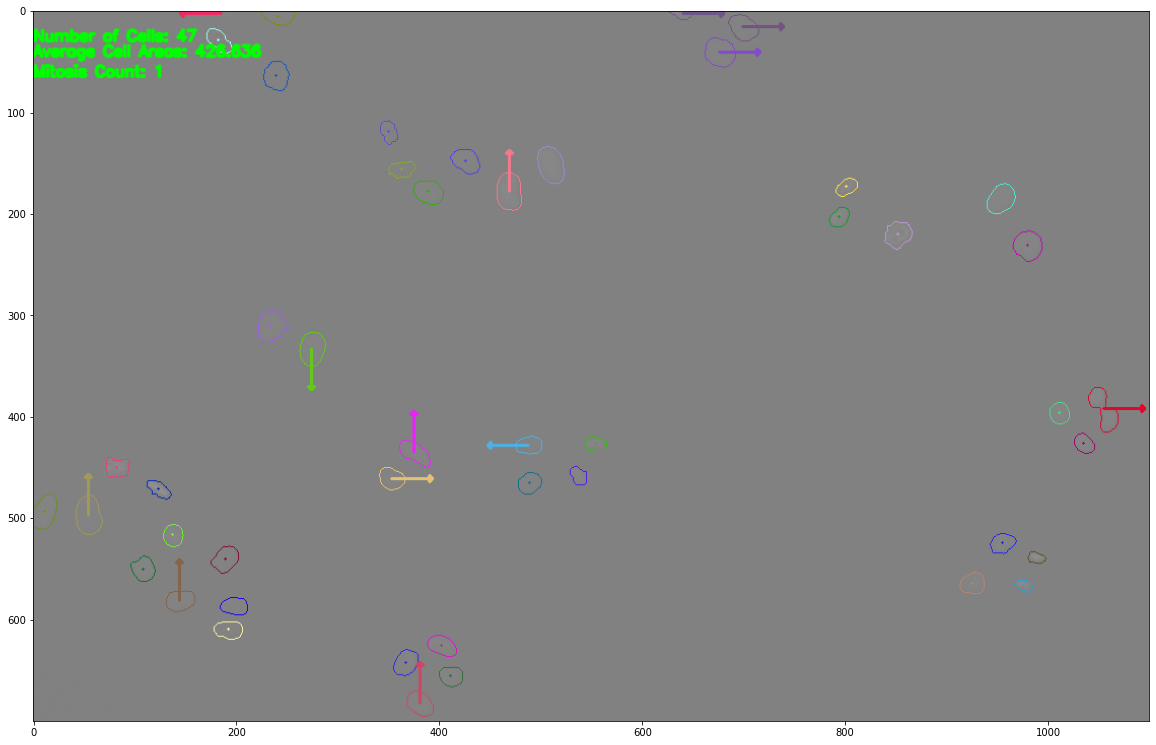

t015.tif


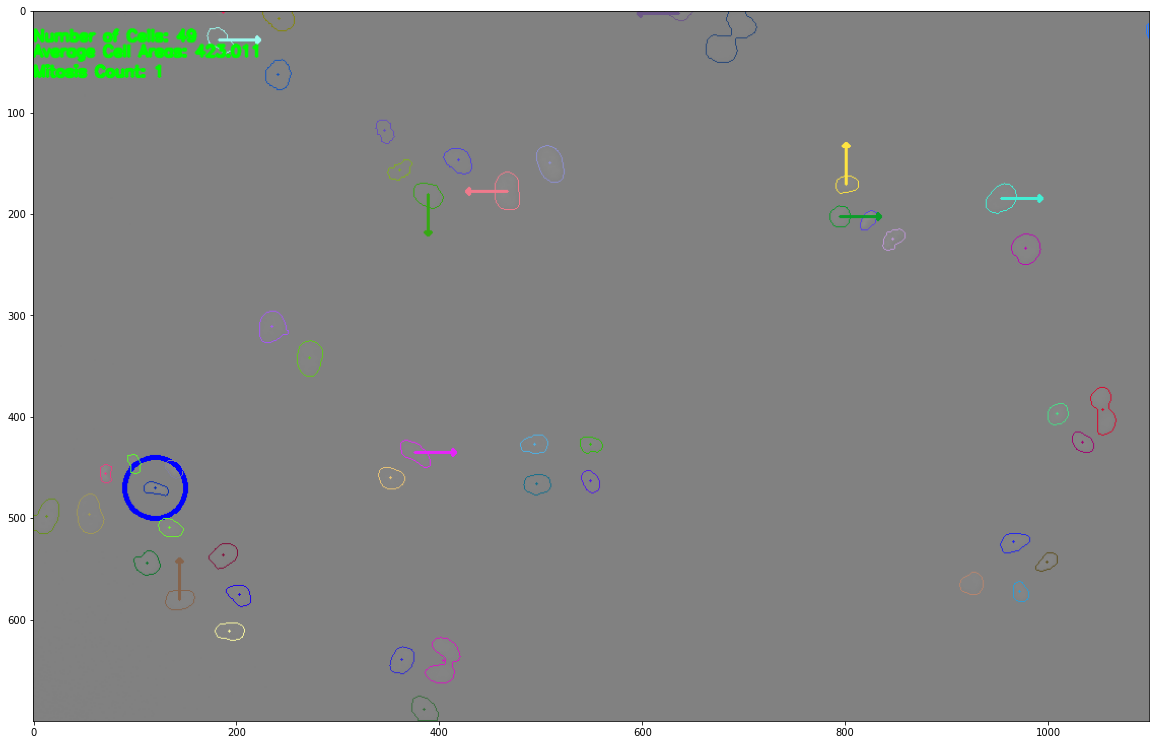

t016.tif


In [ ]:
if __name__ == "__main__":
    main()